In [15]:
!pip install cvxpy

In [16]:
!pip install cvxopt

In [17]:
!pip install scipy

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import jarque_bera
import cvxpy as cp
from cvxopt import matrix, solvers
import requests
import json
import urllib3
urllib3.disable_warnings()
import datetime
import pytz

In [19]:
s = requests.session()
a=s.get('https://open.bymadata.com.ar/#/dashboard', verify=False)

In [20]:
import requests
import pandas as pd
import json
from datetime import datetime
import pytz

# Lista de tickers
tickers = [
    "ALUA", "BBAR", "BMA", "BYMA", "CEPU", "COME", "CRES",
    "EDN", "GFVA", "GGAL", "IRSA", "LOMA", "MIRG", "PAMP",
    "SUP", "TECO2", "TGNO4", "TGSU2", "TRAN", "TXAR",
    "VALO", "YPFD", "AGRO", "BHIP", "BOLT", "MORI", "LEDE", "SEMI", "HARG"
]

# Parámetros de tiempo
inicio = int(datetime(2020, 1, 1, 0, 0).timestamp())
hoy = datetime.now(pytz.timezone('America/Argentina/Buenos_Aires')).timestamp()

# Diccionario para almacenar los DataFrames de cada ticker
dfs = {}

for ticker in tickers:
    params = (
        ('symbol', f'{ticker} 24HS'), ## Nombre de especie y plazo (CDO / 24HS / 48HS)
        ('resolution', 'D'),  ## puede ser D - Diario, S - Semanal, M - Mensual,
        ('from', str(inicio)), ## Unix epoch, se deberia poder armar como int(datetime.datetime(AÑO,MES,DIA,HORA,MINUTOS).timestamp())
        ('to', str(int(hoy))), ## Unix epoch, se deberia poder armar como int(datetime.datetime(AÑO,MES,DIA,HORA,MINUTOS).timestamp())
    )

    response = requests.get('https://open.bymadata.com.ar/vanoms-be-core/rest/api/bymadata/free/chart/historical-series/history', params=params, verify=False)

    if response.status_code == 200:
        data = json.loads(response.text)
        df = pd.DataFrame(data)
        df['t'] = pd.to_datetime(df['t'], unit='s').dt.normalize()
        df.rename({'s':'status', 't':'timestamp', 'c':'close', 'o':'open', 'h':'high', 'l':'low', 'v':'volume'}, axis = 1, inplace=True)
        dfs[ticker] = df
    else:
        print(f"No se pudo obtener datos para {ticker}")

In [21]:
dfs

{'ALUA':     status  timestamp    close     open     high      low   volume
 0       ok 2022-08-01  131.644  133.779  134.728  126.663   738128
 1       ok 2022-08-02  131.170  132.830  134.491  129.035   524363
 2       ok 2022-08-03  130.933  132.830  135.202  126.900   477113
 3       ok 2022-08-04  129.035  132.830  133.779  126.189   969392
 4       ok 2022-08-05  129.035  129.035  131.407  123.342   392522
 ..     ...        ...      ...      ...      ...      ...      ...
 515     ok 2024-09-10  865.000  855.000  873.000  847.000  1130950
 516     ok 2024-09-11  909.000  870.000  910.000  861.000  1225942
 517     ok 2024-09-12  916.000  909.000  921.000  903.000  1020487
 518     ok 2024-09-13  919.000  915.000  924.000  882.000   660957
 519     ok 2024-09-16  926.000  920.000  931.000  910.000   822574
 
 [520 rows x 7 columns],
 'BBAR':     status  timestamp     close      open      high       low  volume
 0       ok 2022-08-01   186.353   195.409   196.537   181.731  112017

In [22]:
# Concatena todos los DataFrames en uno solo
data = pd.concat(dfs.values(), keys=dfs.keys())

# Restablece el índice para que 'timestamp' sea una columna y no un índice
data = data.reset_index()

# Renombra las columnas para que sea más claro
data.rename(columns={'level_0': 'Ticker', 'timestamp': 'Date'}, inplace=True)

# Pivotea los datos para obtener los precios de cierre con fechas en filas y tickers en columnas
data = data.pivot(index='Date', columns='Ticker', values='close')

# Convierte todos los valores a numérico, por si acaso algunos fueron leídos como strings
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Convierte la columna de índice 'Date' a datetime si no lo está ya
data.index = pd.to_datetime(data.index)

# Ordena el DataFrame por la fecha de manera descendente (las fechas más recientes primero)
data.sort_index(ascending=False, inplace=True)

# Ahora pivot_data es similar a lo que se muestra en tu segunda imagen
data

Ticker,AGRO,ALUA,BBAR,BHIP,BMA,BOLT,BYMA,CEPU,COME,CRES,...,MORI,PAMP,SEMI,TECO2,TGNO4,TGSU2,TRAN,TXAR,VALO,YPFD
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-16,55.600,926.000,4705.000,416.000,8340.000,53.10,334.000,1305.000,280.500,1145.000,...,356.50,2910.00,138.000,2070.000,3235.00,5300.00,1855.0,862.000,320.500,29775.00
2024-09-13,56.900,919.000,4755.000,425.500,8450.000,53.10,340.500,1300.000,280.500,1135.000,...,368.00,2970.00,139.250,2015.000,3260.00,5300.00,1845.0,841.000,323.500,29200.00
2024-09-12,56.400,916.000,4610.000,427.000,8200.000,53.40,339.000,1270.000,279.500,1140.000,...,356.50,2965.00,135.500,2020.000,3285.00,5230.00,1790.0,836.000,324.000,29025.00
2024-09-11,56.100,909.000,4570.000,429.500,7950.000,53.20,332.000,1260.000,281.000,1105.000,...,345.00,2950.00,138.000,2005.000,3320.00,5130.00,1715.0,828.000,324.000,28675.00
2024-09-10,52.600,865.000,4505.000,428.500,7700.000,52.30,331.500,1185.000,281.000,1055.000,...,340.50,2850.00,135.500,1930.000,3155.00,4995.00,1650.0,799.000,319.500,28550.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,5.138,129.035,190.900,9.549,286.818,5.61,37.747,99.894,14.688,135.721,...,16.30,275.25,2.788,240.341,129.50,339.30,83.4,139.874,50.821,1088.90
2022-08-04,4.929,129.035,190.298,9.596,292.823,5.34,37.323,96.866,14.275,135.912,...,16.50,279.85,2.848,242.337,116.50,331.45,77.0,139.432,50.821,1086.55
2022-08-03,4.978,130.933,193.567,9.735,297.394,5.13,36.946,97.261,13.862,135.111,...,16.45,276.40,2.801,243.810,113.00,329.95,73.9,138.562,50.193,1094.45


In [47]:
df1_return = data / data.shift(-1) - 1

df1_return = df1_return.dropna()  # Elimina la primera fila que contiene valores nulos

df1_return

df_invertido = df.iloc[::-1]


In [48]:
df1_return = df1_return[['ALUA', 'BMA', 'GGAL', 'YPFD']]

weights = [0.4, 0.4, 0.2, 0.0]  # Ajusta según tus proporciones, asegurándote de que sumen 1
portfolio_returns = df1_return.dot(weights)

# Calcular métricas de rentabilidad como antes
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
annual_return = portfolio_returns.mean() * 252
annual_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility

print(f'Retorno anual: {annual_return:.2%}')
print(f'Volatilidad anual: {annual_volatility:.2%}')
print(f'Ratio de Sharpe: {sharpe_ratio:.2f}')

Retorno anual: 150.07%
Volatilidad anual: 51.00%
Ratio de Sharpe: 2.94


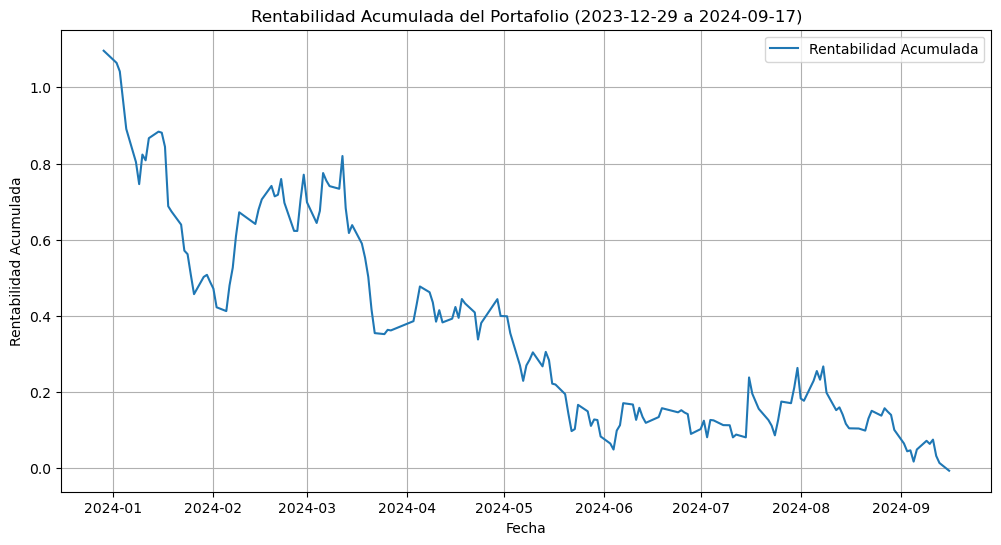

In [49]:
start_date = '2023-12-29'
end_date = '2024-09-17'
period_returns = portfolio_returns.loc[start_date:end_date]

# Calcular la rentabilidad acumulada para el periodo específico
# Usar cumprod() para obtener la serie temporal de rentabilidad acumulada
cumulative_return_period = (1 + period_returns).cumprod() - 1

# Graficar la rentabilidad acumulada para el periodo específico
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return_period.index, cumulative_return_period, label='Rentabilidad Acumulada')
plt.title(f'Rentabilidad Acumulada del Portafolio ({start_date} a {end_date})')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad Acumulada')
plt.legend()
plt.grid(True)
plt.show()